In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
#   LEARN FCN00
#

from __future__ import print_function
import argparse
import os

import numpy as np
import pickle
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray, img_dice_coeff
from create_fcn import create_fcn01, create_fcn02, create_fcn00

np.random.seed(2016)

In [4]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2.*intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [5]:
def load_fnames(paths):
    f = open(paths)
    data1 = f.read()
    f.close()
    lines = data1.split('\n')
    #print(len(lines))
    # 最終行は空行なので消す
    del(lines[len(lines)-1])
    #print(len(lines))
    return lines

In [6]:
def make_fnames(fnames,fpath,fpath_mask,mask_ext):
    fnames_img = [];
    fnames_mask= [];
    
    for i in range(len(fnames)):
        fnames_img.append(fpath + '/' + fnames[i]);
        fnames_mask.append(fpath_mask + '/' + mask_ext + fnames[i]);
        
    return [fnames_img,fnames_mask]

In [7]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    dname_checkpoints = 'checkpoints_fcn00'
    dname_checkpoints_fcn01 = 'checkpoints_fcn01'
    dname_outputs = 'outputs'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = "history.pkl"

    # definision of mode, LEARN or TEST or SHOW_HISTORY
    #mode = "LEARN"
    #mode = "SHOW_HISTORY"
    #mode = "TEST"

    # モデルを作成
    print('creating model fcn00 and fcn01...')
    #model_fcn02 = create_fcn02(target_size)
    model_fcn01 = create_fcn01(target_size)
    model_fcn00 = create_fcn00(target_size)
    
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)

creating model fcn00 and fcn01...


In [9]:
#
#   LEARNING MODE
#
if mode == "LEARN":
    # Read Learning Data
    fnames = load_fnames('data/list_train_01.txt')
    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data/img','data/mask','OperatorA_')

    X_train = load_imgs_asarray(fpaths_xs_train, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_train = load_imgs_asarray(fpaths_ys_train, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering) 

    # Read Validation Data
    fnames = load_fnames('data/list_valid_01.txt')
    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data/img','data/mask','OperatorA_')

    X_valid = load_imgs_asarray(fpaths_xs_valid, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_valid = load_imgs_asarray(fpaths_ys_valid, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)     

    print('==> ' + str(len(X_train)) + ' training images loaded')
    print('==> ' + str(len(Y_train)) + ' training masks loaded')
    print('==> ' + str(len(X_valid)) + ' validation images loaded')
    print('==> ' + str(len(Y_valid)) + ' validation masks loaded')

    # 前処理
    print('computing mean and standard deviation...')
    mean = np.mean(X_train, axis=(0, 2, 3))
    std = np.std(X_train, axis=(0, 2, 3))
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    print('saving mean and standard deviation to ' + fname_stats + '...')
    stats = {'mean': mean, 'std': std}
    np.savez(dname_checkpoints + '/' + fname_stats, **stats)
    print('==> done')

    print('globally normalizing data...')
    for i in range(3):
        X_train[:, i] = (X_train[:, i] - mean[i]) / std[i]
        X_valid[:, i] = (X_valid[:, i] - mean[i]) / std[i]
    Y_train /= 255
    Y_valid /= 255
    print('==> done')

==> 1452 training images loaded
==> 1452 training masks loaded
==> 527 validation images loaded
==> 527 validation masks loaded
computing mean and standard deviation...
==> mean: [130.65465  91.2685   76.63643]
==> std : [55.2817   43.990963 43.113483]
saving mean and standard deviation to stats01.npz...
==> done
globally normalizing data...
==> done


In [10]:
    # モデルに学習済のfcn02 Weightをロードする
    epoch = 200
    fname_weights = 'model_weights_%02d.h5'%(epoch)
    fpath_weights_fcn01 = os.path.join(dname_checkpoints_fcn01, fname_weights)
    model_fcn01.load_weights(fpath_weights_fcn01)
    #print('==> done')

    # load weights from Learned U-NET
    layer_names = ['conv1_1','conv1_2','conv2_1','conv2_2','conv3_1','conv3_2',
                   'conv4_1','conv4_2','conv5_1', 'conv5_2',
                'up1_1', 'up1_2', 'up2_1', 'up2_2', 'up3_1', 'up3_2', 'up4_1', 
                   'up4_2', 'conv_fin']
    layer_names = ['conv1_1','conv1_2','conv2_1','conv2_2',
                'up1_1', 'up1_2', 'up2_1', 'up2_2', 'conv_fin']
    
    print('copying layer weights')
    for name in layer_names:
        print(name)
        model_fcn00.get_layer(name).set_weights(model_fcn01.get_layer(name).get_weights())
        model_fcn00.get_layer(name).trainable = True

copying layer weights
conv1_1
conv1_2
conv2_1
conv2_2
up1_1
up1_2
up2_1
up2_2
conv_fin


In [12]:
    # 損失関数，最適化手法を定義
    adam = Adam(lr=1e-5)
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.1, nesterov=True)
    #rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model_fcn00.compile(optimizer=adam, loss=dice_coef_loss, metrics=[dice_coef])

    # 構造・重みを保存するディレクトリーの有無を確認
    dpath_checkpoints = os.path.join(dpath_this, dname_checkpoints)
    if not os.path.isdir(dpath_checkpoints):
        os.mkdir(dpath_checkpoints)

    # 重みを保存するためのオブジェクトを用意
    fname_weights = "model_weights_{epoch:02d}.h5"
    fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
    checkpointer = ModelCheckpoint(filepath=fpath_weights, save_best_only=False)      

In [13]:
    # トレーニングを開始
    print('start training...')
    history = model_fcn00.fit(X_train[:,:,:,:], Y_train[:,:,:,:], batch_size=64, epochs=200, verbose=1,
                  shuffle=True, validation_data=(X_valid, Y_valid), callbacks=[checkpointer])

start training...
Train on 1452 samples, validate on 527 samples
Epoch 1/200
1452/1452 [==============================] - 104s 72ms/step - loss: -0.0399 - dice_coef: 0.0399 - val_loss: -0.0657 - val_dice_coef: 0.0657
Epoch 2/200
1452/1452 [==============================] - 65s 44ms/step - loss: -0.1389 - dice_coef: 0.1389 - val_loss: -0.3452 - val_dice_coef: 0.3452
Epoch 3/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.5216 - dice_coef: 0.5216 - val_loss: -0.6759 - val_dice_coef: 0.6759
Epoch 4/200
1452/1452 [==============================] - 65s 44ms/step - loss: -0.6760 - dice_coef: 0.6760 - val_loss: -0.7220 - val_dice_coef: 0.7220
Epoch 5/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.7267 - dice_coef: 0.7267 - val_loss: -0.7455 - val_dice_coef: 0.7455
Epoch 6/200
1452/1452 [==============================] - 65s 45ms/step - loss: -0.7345 - dice_coef: 0.7345 - val_loss: -0.7634 - val_dice_coef: 0.7634
Epoch 7/200
1452/1452 [=====

KeyboardInterrupt: 

In [11]:
    # Save History
    f = open(dname_checkpoints + '/' + fname_history,'wb')
    pickle.dump(history.history,f)
    f.close

<function BufferedWriter.close>

In [12]:
#
#  TEST MODE
#
mode = 'TEST'
if mode == "TEST":
    # Prediction (test) mode
    
    # Read Test Data
    #fnames = load_fnames('data/list_test_01.txt')
    fnames = load_fnames('data.nnlab/list_test.txt')

    #[fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
    [fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'data.nnlab/image','data.nnlab/gt','')

    X_test = load_imgs_asarray(fpaths_xs_test, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    #Y_test = load_imgs_asarray(fpaths_ys_test, grayscale=True, target_size=target_size,
    #                            dim_ordering=dim_ordering)

    # トレーニング時に計算した平均・標準偏差をロード    
    print('loading mean and standard deviation from ' + fname_stats + '...')
    stats = np.load(dname_checkpoints + '/' + fname_stats)
    mean = stats['mean']
    std = stats['std']
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    for i in range(3):
        X_test[:, i] = (X_test[:, i] - mean[i]) / std[i]
    print('==> done')

loading mean and standard deviation from stats01.npz...
==> mean: [130.65465  91.2685   76.63643]
==> std : [55.2817   43.990963 43.113483]
==> done


==> done
saving outputs as images...
==> done


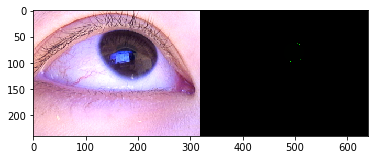

0: Dice eval av. : 0.000000


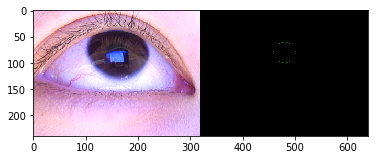

1: Dice eval av. : 0.000000


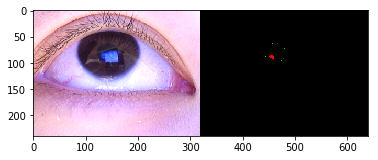

2: Dice eval av. : 0.029630


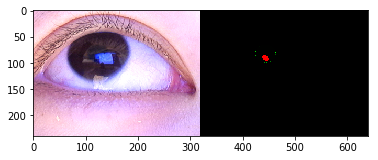

3: Dice eval av. : 0.068675


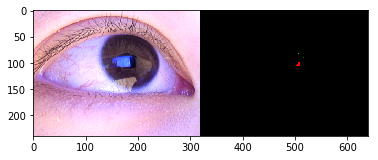

4: Dice eval av. : 0.076410


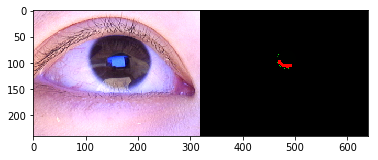

5: Dice eval av. : 0.112449


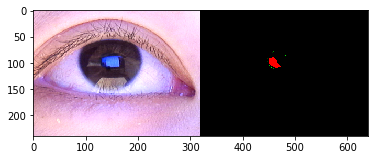

6: Dice eval av. : 0.157937


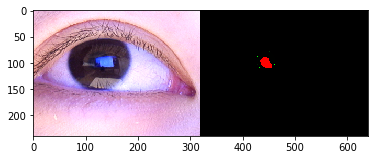

7: Dice eval av. : 0.199968


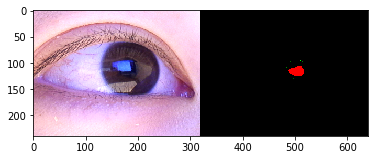

8: Dice eval av. : 0.238728


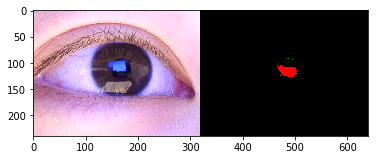

9: Dice eval av. : 0.279253


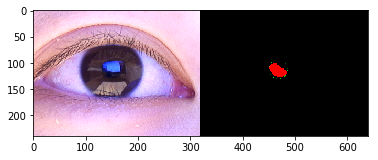

10: Dice eval av. : 0.319921


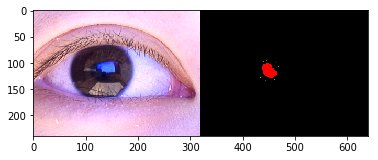

11: Dice eval av. : 0.342891


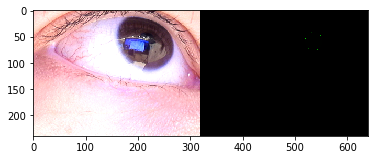

12: Dice eval av. : 0.316514


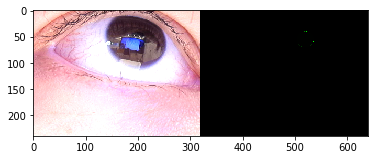

13: Dice eval av. : 0.293906


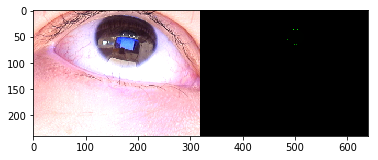

14: Dice eval av. : 0.274312


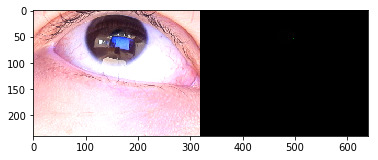

15: Dice eval av. : 0.257168


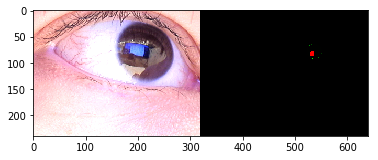

16: Dice eval av. : 0.250951


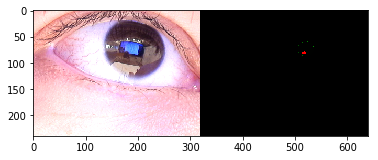

17: Dice eval av. : 0.242031


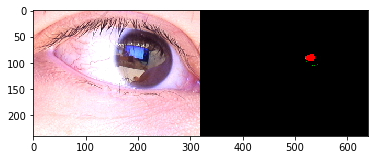

18: Dice eval av. : 0.252581


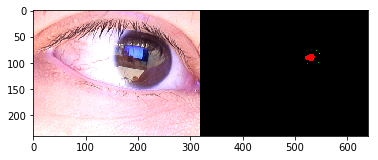

19: Dice eval av. : 0.262030


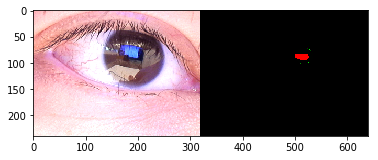

20: Dice eval av. : 0.273253


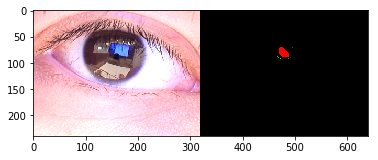

21: Dice eval av. : 0.282335


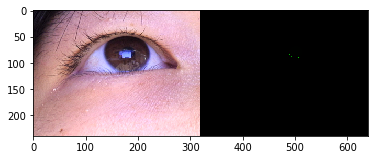

22: Dice eval av. : 0.270060


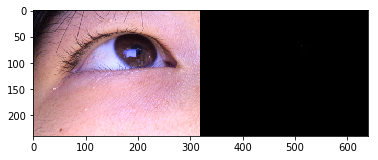

23: Dice eval av. : 0.258807


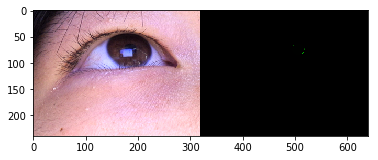

24: Dice eval av. : 0.248455


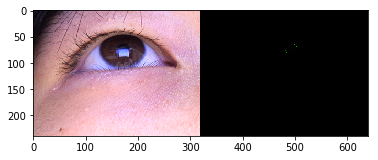

25: Dice eval av. : 0.238899


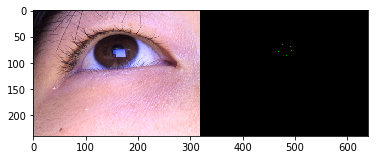

26: Dice eval av. : 0.230051


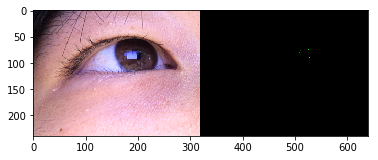

27: Dice eval av. : 0.221835


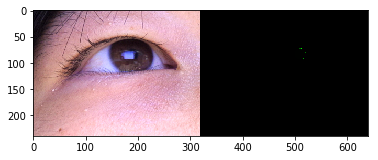

28: Dice eval av. : 0.214186


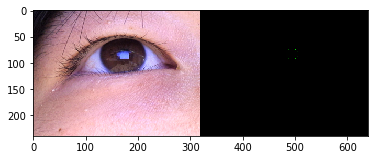

29: Dice eval av. : 0.207046


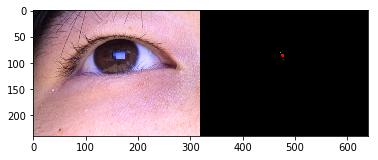

30: Dice eval av. : 0.204552


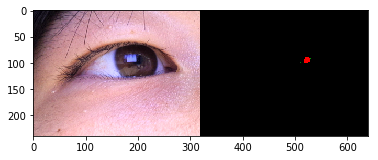

31: Dice eval av. : 0.214302


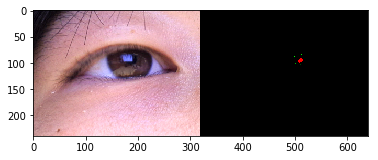

32: Dice eval av. : 0.216195


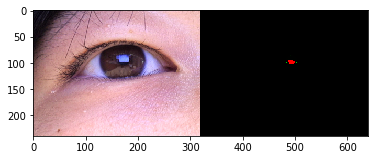

33: Dice eval av. : 0.220570


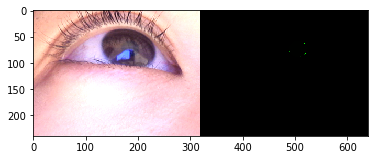

34: Dice eval av. : 0.214268


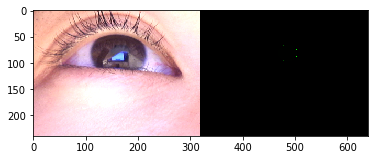

35: Dice eval av. : 0.208316


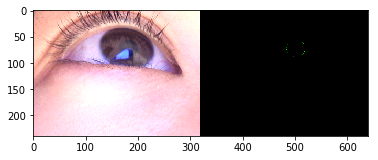

36: Dice eval av. : 0.202686


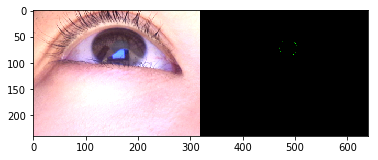

37: Dice eval av. : 0.197352


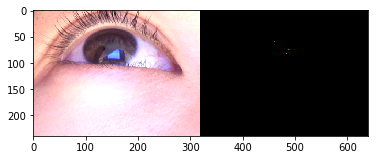

38: Dice eval av. : 0.192292


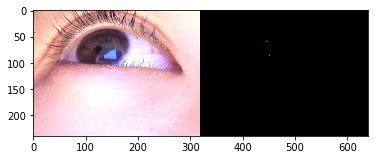

39: Dice eval av. : 0.187485


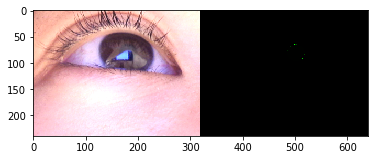

40: Dice eval av. : 0.182912


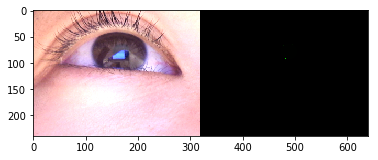

41: Dice eval av. : 0.178557


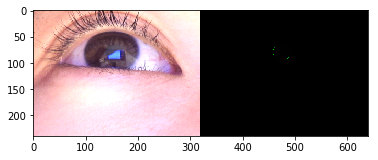

42: Dice eval av. : 0.174404


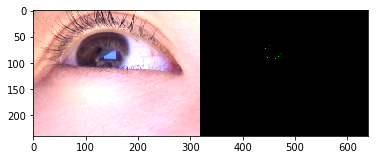

43: Dice eval av. : 0.170441


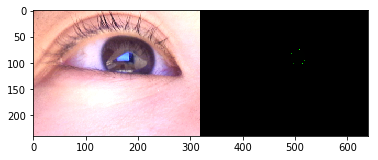

44: Dice eval av. : 0.166653


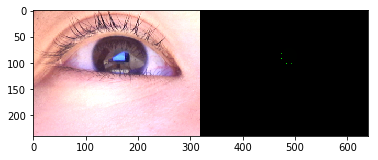

45: Dice eval av. : 0.163030


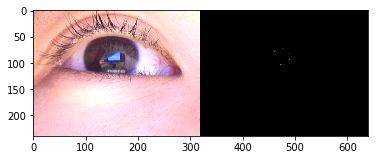

46: Dice eval av. : 0.159562


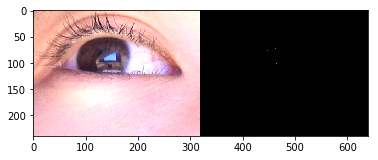

47: Dice eval av. : 0.156237


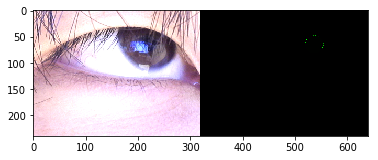

48: Dice eval av. : 0.153049


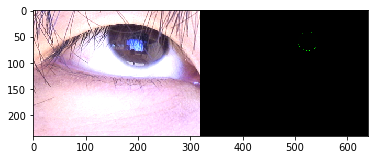

49: Dice eval av. : 0.149988


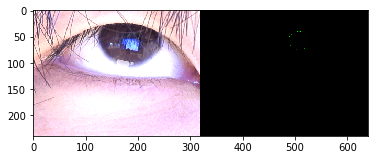

50: Dice eval av. : 0.147047


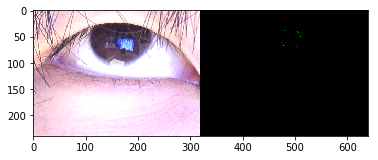

51: Dice eval av. : 0.144219


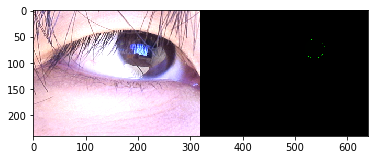

52: Dice eval av. : 0.141498


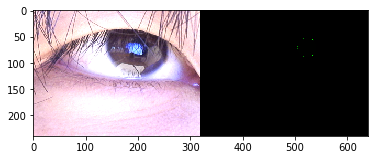

53: Dice eval av. : 0.138878


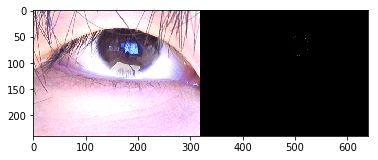

54: Dice eval av. : 0.136353


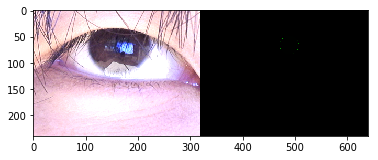

55: Dice eval av. : 0.133918


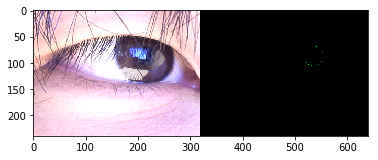

56: Dice eval av. : 0.131568


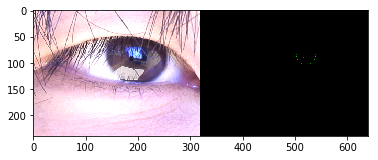

57: Dice eval av. : 0.129333


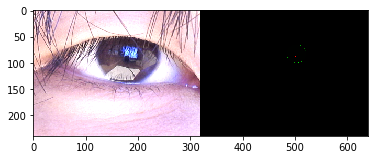

58: Dice eval av. : 0.127272


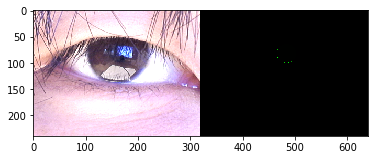

59: Dice eval av. : 0.125151


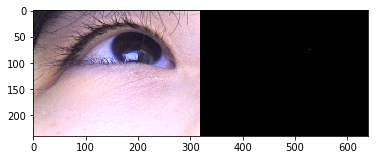

60: Dice eval av. : 0.123099


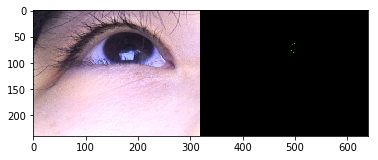

61: Dice eval av. : 0.121114


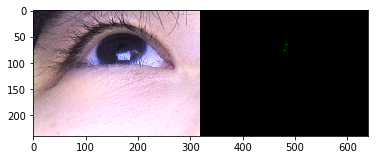

62: Dice eval av. : 0.119191


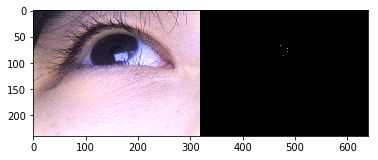

63: Dice eval av. : 0.117329


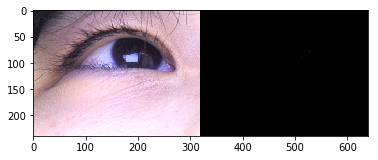

64: Dice eval av. : 0.115524


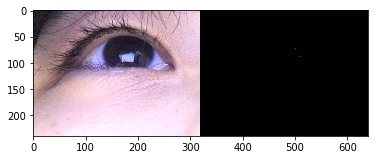

65: Dice eval av. : 0.113774


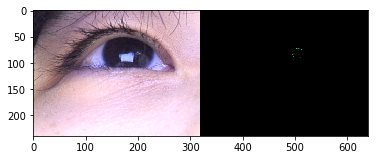

66: Dice eval av. : 0.112075


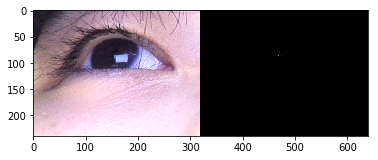

67: Dice eval av. : 0.110427


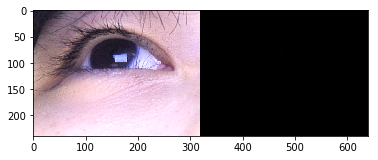

68: Dice eval av. : 0.108827


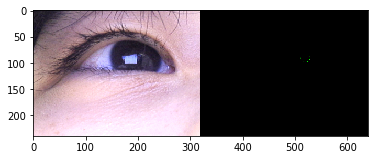

69: Dice eval av. : 0.107272


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [25]:
    from PIL import Image
    import matplotlib.pyplot as plt

#    for ep in range(10,200,10):

    # 学習済みの重みをロード
    epoch = 100
    fname_weights = 'model_weights_%02d.h5'%(epoch)
    fpath_weights = os.path.join(dname_checkpoints, fname_weights)
    model_fcn00.load_weights(fpath_weights)
    print('==> done')

    # テストを開始
    outputs = model_fcn00.predict(X_test)
    #    outputs = model_fcn02.predict(X_test)

    # 出力を画像として保存
    dname_outputs = './outputs/'
    if not os.path.isdir(dname_outputs):
        print('create directory: %s'%(dname_outputs))
        os.mkdir(dname_outputs)

    print('saving outputs as images...')
    n = 0
    for i, array in enumerate(outputs):
        array = np.where(array > 0.5, 1, 0) # 二値に変換
        array = array.astype(np.float32)
        img_out = array_to_img(array, dim_ordering)
        # fpath_out = os.path.join(dname_outputs, fnames[i])
        fpath_out = os.path.join(dname_outputs, "%05d.png"%(n))
        img_out.save(fpath_out)
        n = n + 1

    print('==> done')

    n = 0
    dice_eval = []

    for i in range(len(fpaths_xs_test)):
        # テスト画像
        im1 = Image.open(fpaths_xs_test[i])
        im1 = im1.resize((320,240)) 
        # 出力結果
        im2 = Image.open(os.path.join(dname_outputs, "%05d.png"%(n)))
        im2 = im2.resize((320,240))
        # Grond Truth
        im3 = Image.open(fpaths_ys_test[i])
        im3 = im3.resize((320,240))
        im3 = im3.convert('L')
        
        im2_d = np.zeros((240,320,3), 'uint8')
        im2_d[:,:,0] = np.array(im2)
        im2_d[:,:,1] = np.array(im3)*255
        im2_d[:,:,2] = 0

        # Compute dice coeff
        im2a = np.array(im2)
        im2a[im2a > 0] = 1
        im3a = np.array(im3)
        im3a[im3a > 0] = 1

        overlap_a = np.array(im2a) * np.array(im3a)
        overlap_b = np.array(im2a) + np.array(im3a)
        #print('%03d: Dice Coeff = %f'%(i, 2*sum(sum(overlap_a))/sum(sum(overlap_b))))
        #print('%f'%img_dice_coeff(im2,im3))
        dice_eval.append(2*sum(sum(overlap_a))/sum(sum(overlap_b)))

        plt.imshow(np.hstack((np.array(im1),np.array(im2_d))))
        plt.show()

        print('%d: Dice eval av. : %f'%(n,np.mean(np.array(dice_eval))))
        n = n + 1

checkpoints_fcn00/history.pkl


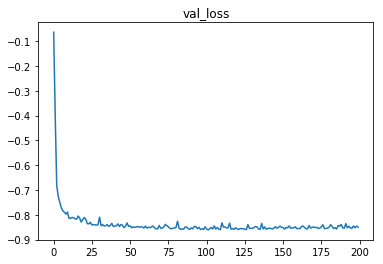

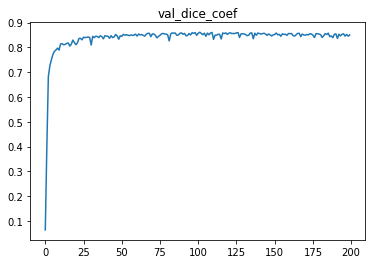

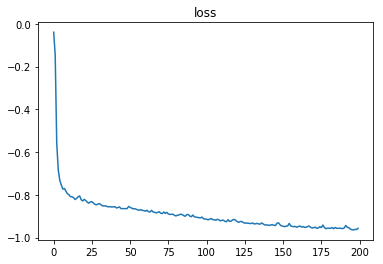

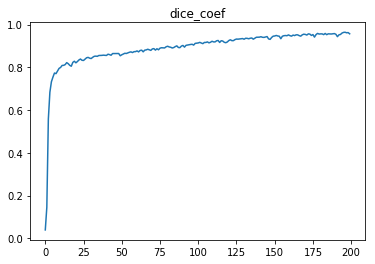

In [19]:
#
#   Show History
#
mode = "SHOW_HISTORY"
if mode == "SHOW_HISTORY":
    # load pickle
    print(dname_checkpoints + '/' + fname_history)
    history = pickle.load(open(dname_checkpoints + '/' + fname_history, 'rb'))
    
    for k in history.keys():
        plt.plot(history[k])
        plt.title(k)
        plt.show()
